In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
import os
#drive.mount('/content/drive')

In [ ]:
os.chdir('/content/drive/My Drive/CS 230: Deep Learning/stability-flexibility-tradeoff-master/Participant Data')
df_exp_1 = pd.read_csv('Experiment 1/combinedData_Exp1.csv')

# Linear Baseline

In [ ]:
## Linear MAE and MSE Together
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming df_exp_1 is already defined and loaded with the necessary data

# Step 1: Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Select useful columns
df_exp_1_input = df_exp_1_task[['subject', 'stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc', 'RT']]

# Remove any rows where switchType is 'n'
df_exp_1_input = df_exp_1_input[df_exp_1_input['switchType'] != 'n']

# Encode categorical variables
binary_cols = ['taskCue', 'stimCongruency', 'switchType']
binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    df_exp_1_input[col] = df_exp_1_input[col].map(binary_mapping)

# Step 2: Define features and target
features = ['stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc']
target = 'RT'

# Remove any rows with missing RT
df_exp_1_input = df_exp_1_input.dropna(subset=['RT'])

# Normalize the target values by dividing by 1000 only for normalizing during modeling (we'll inverse this later)
df_exp_1_input[target] = df_exp_1_input[target] / 1000.0

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_exp_1_input[features])

# Ensure the array datatypes are correct for modeling
X_array = X_scaled.astype(np.float32)
y_array = df_exp_1_input[target].values.astype(np.float32)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.1, random_state=42)

# Fit the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# Calculate MSE and MAE for the train and test sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f'MSE on Training set: {mse_train:.4f}')
print(f'MSE on Test set: {mse_test:.4f}')
print(f'MAE on Training set: {mae_train:.4f}')
print(f'MAE on Test set: {mae_test:.4f}')

# Calculate the Pearson correlation coefficient directly for the train and test sets
corr_train = np.corrcoef(y_train, y_pred_train)[0, 1]
corr_test = np.corrcoef(y_test, y_pred_test)[0, 1]

print(f'Correlation Coefficient on Training set: {corr_train:.4f}')
print(f'Correlation Coefficient on Test set: {corr_test:.4f}')

# Convert predictions back to milliseconds for plotting and comparison
y_train_ms = y_train * 1000
y_test_ms = y_test * 1000
y_pred_train_ms = y_pred_train * 1000
y_pred_test_ms = y_pred_test * 1000

# Scatter plot of predictions vs actual values for the test set
plt.figure(figsize=(10, 5))
plt.scatter(y_test_ms, y_pred_test_ms, label='Test Data', alpha=0.7, color='blue')
plt.plot([min(y_test_ms), max(y_test_ms)],
         [min(y_test_ms), max(y_test_ms)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual RT (ms)')
plt.ylabel('Predicted RT (ms)')
plt.legend()
plt.title('Actual vs Predicted Reaction Time (Test Set)')
plt.show()

# Create the binned line plot
bin_size = 20
num_bins = len(y_test_ms) // bin_size
trial_bins = np.arange(num_bins) * bin_size + bin_size // 2  # Midpoint of each bin

actual_means = [y_test_ms[i * bin_size:(i + 1) * bin_size].mean() for i in range(num_bins)]
predicted_means = [y_pred_test_ms[i * bin_size:(i + 1) * bin_size].mean() for i in range(num_bins)]

plt.figure(figsize=(12, 6))
plt.plot(trial_bins, actual_means, label='Actual RT (ms)', color='blue')
plt.plot(trial_bins, predicted_means, label='Predicted RT (ms)', color='red')
plt.xlabel('Trial Number (Binned)')
plt.ylabel('Reaction Time (ms)')
plt.legend()
plt.title('Binned Actual vs Predicted Reaction Times')
plt.show()

# Dynamic Variational Autoencoder

Epoch [10/30], Loss: 0.3637
Epoch [20/30], Loss: 0.0932
Epoch [30/30], Loss: 0.0617
Test Loss: 0.0636
Correlation coefficient: 0.23091882775240696


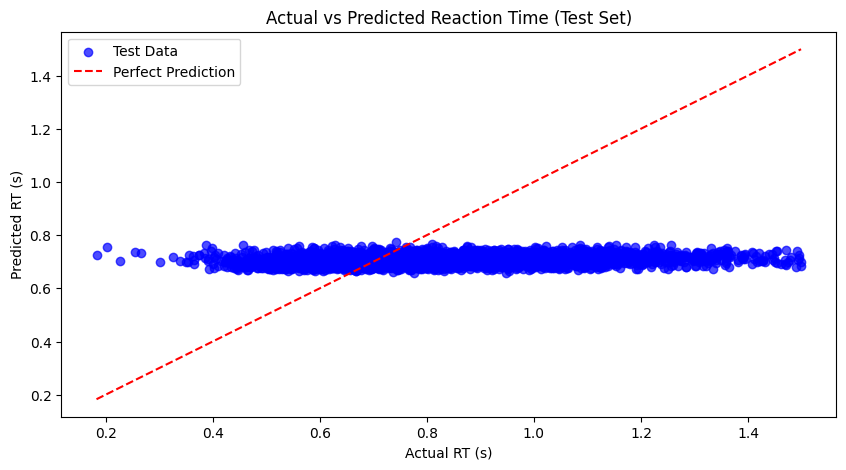

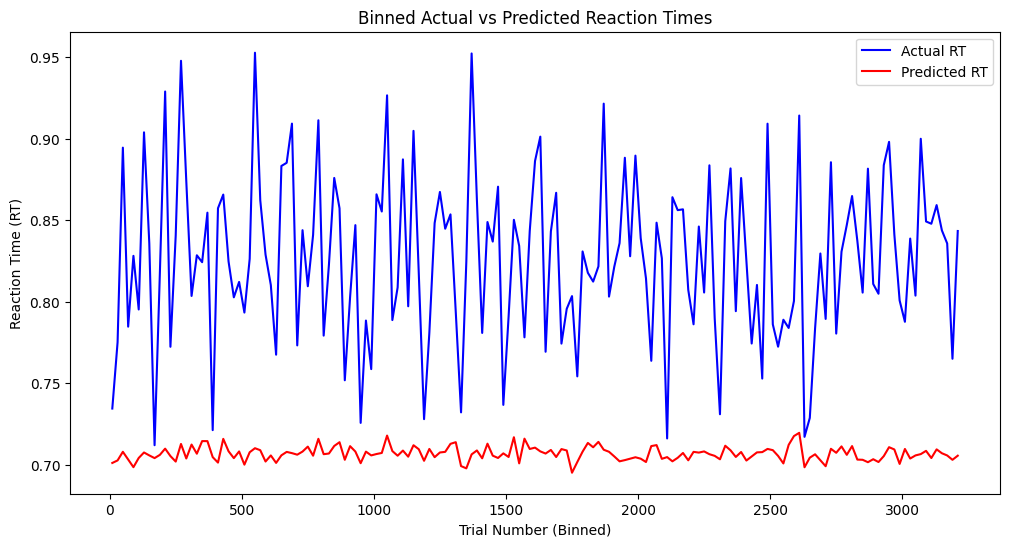

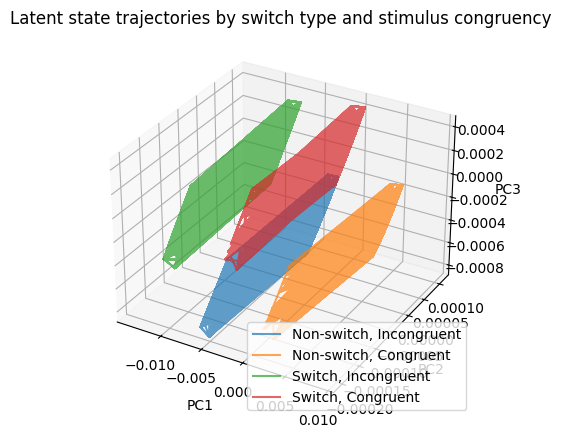

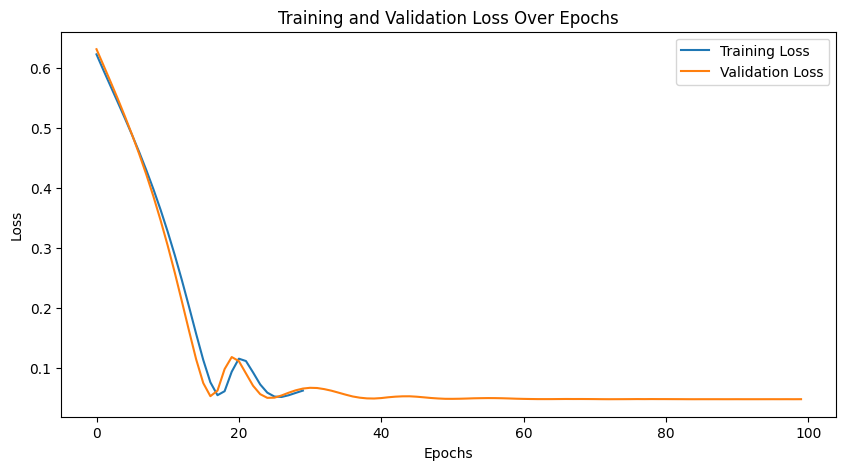

Test Loss: 0.0636
Correlation coefficient: 0.23244140627592597


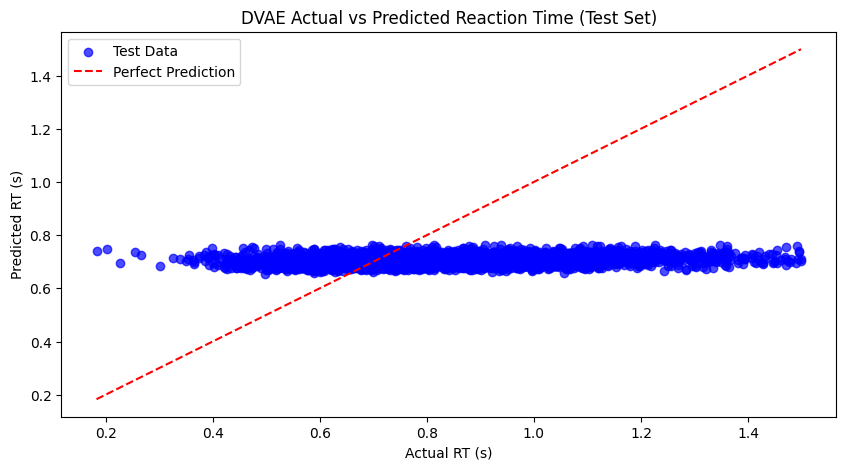

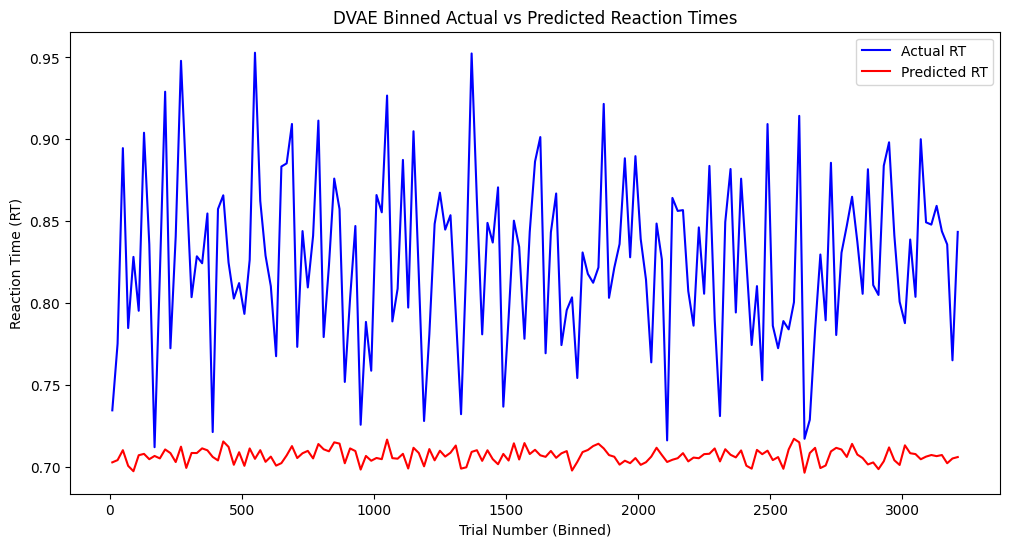

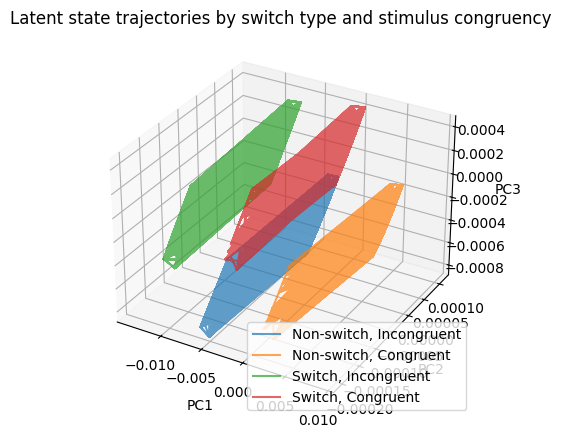

In [ ]:
## EVERYTHING IN SECONDS AND MSE

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming df_exp_1 is already defined and loaded with the necessary data

# Step 1: Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Select useful columns
df_exp_1_input = df_exp_1_task[['subject', 'stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc', 'RT']]

# Remove any rows where switchType is 'n'
df_exp_1_input = df_exp_1_input[df_exp_1_input['switchType'] != 'n']

# Encode categorical variables
binary_cols = ['taskCue', 'stimCongruency', 'switchType']
binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    df_exp_1_input[col] = df_exp_1_input[col].map(binary_mapping)

# Step 2: Define features and target
features = ['stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc']
target = 'RT'

# Remove any rows with missing RT
df_exp_1_input = df_exp_1_input.dropna(subset=['RT'])

# Normalize the target values by dividing by 1000 for readability in seconds
df_exp_1_input[target] = df_exp_1_input[target] / 1000.0

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_exp_1_input[features])

# Ensure the array datatypes are correct for PyTorch
X_array = X_scaled.astype(np.float32)
y_array = df_exp_1_input[target].values.astype(np.float32)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_array, y_array, df_exp_1_input.index, test_size=0.1, random_state=42, stratify=df_exp_1_input[['switchType', 'stimCongruency']]
)

# Convert to PyTorch tensors with dtype=torch.float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logv = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn[-1].unsqueeze(0).repeat(self.num_layers, 1, 1)
        mean = self.hidden2mean(hn[-1])
        logv = self.hidden2logv(hn[-1])
        return mean, logv, (hn, cn)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.hidden2output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.hidden2output(out[:, -1, :])
        return out, hidden

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_layers=2, dropout=0.2):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, num_layers, dropout)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim, num_layers, dropout)

    def reparameterize(self, mean, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        mean, logv, hidden = self.encoder(x)
        z = self.reparameterize(mean, logv).unsqueeze(1)
        out, _ = self.decoder(z, hidden)
        return out, mean, logv

    def loss_function(self, recon_x, x, mean, logv):
        MSE = F.mse_loss(recon_x, x, reduction='mean')
        KLD = -0.5 * torch.mean(1 + logv - mean.pow(2) - logv.exp())
        return MSE + KLD

# Training the model
input_dim = X_train_tensor.shape[2]
hidden_dim = 128
latent_dim = 64
output_dim = 1
num_layers = 4
dropout = 0.2

model = VAE(input_dim, hidden_dim, latent_dim, output_dim, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    recon_x, mean, logv = model(X_train_tensor)
    loss = model.loss_function(recon_x, y_train_tensor, mean, logv)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




# Evaluation on the test set
model.eval()
with torch.no_grad():
    recon_x, mean, logv = model(X_test_tensor)
    eval_loss = model.loss_function(recon_x, y_test_tensor, mean, logv)
    print(f'Test Loss: {eval_loss.item():.4f}')

    y_test_numpy = y_test_tensor.numpy()
    y_pred_numpy = recon_x.numpy()

    correlation = np.corrcoef(y_test_numpy.flatten(), y_pred_numpy.flatten())[0, 1]
    print(f"Correlation coefficient: {correlation}")

    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_numpy, y_pred_numpy, label='Test Data', alpha=0.7, color='blue')
    plt.plot([min(y_test_numpy), max(y_test_numpy)],
             [min(y_test_numpy), max(y_test_numpy)],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual RT (s)')
    plt.ylabel('Predicted RT (s)')
    plt.legend()
    plt.title('Actual vs Predicted Reaction Time (Test Set)')
    plt.show()

    bin_size = 20
    num_bins = len(y_test_numpy) // bin_size
    trial_bins = np.arange(num_bins) * bin_size + bin_size // 2

    actual_means = [y_test_numpy[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]
    predicted_means = [y_pred_numpy[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]

    plt.figure(figsize=(12, 6))
    plt.plot(trial_bins, actual_means, label='Actual RT', color='blue')
    plt.plot(trial_bins, predicted_means, label='Predicted RT', color='red')
    plt.xlabel('Trial Number (Binned)')
    plt.ylabel('Reaction Time (RT)')
    plt.legend()
    plt.title('Binned Actual vs Predicted Reaction Times')
    plt.show()

# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Latent space analysis
model.eval()
with torch.no_grad():
    mean_train, logv_train, _ = model.encoder(X_train_tensor)
    mean_test, logv_test, _ = model.encoder(X_test_tensor)

# Combine train and test latent variables for PCA
latent_vars = torch.cat((mean_train, mean_test), dim=0).cpu().numpy()

# Perform PCA
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent_vars)

# Create a condition array for coloring in the plots
combined_conditions = np.concatenate((
    df_exp_1_input.loc[train_indices, ['switchType', 'stimCongruency']].values,
    df_exp_1_input.loc[test_indices, ['switchType', 'stimCongruency']].values
), axis=0)

# Convert conditions to a single integer for easier plotting
condition_labels = combined_conditions[:, 0] * 2 + combined_conditions[:, 1]

# Plot the trajectories for each task cue and stim congruency
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

condition_mapping = {
    0: 'Non-switch, Incongruent',
    1: 'Non-switch, Congruent',
    2: 'Switch, Incongruent',
    3: 'Switch, Congruent'
}

for cond in np.unique(condition_labels):
    mask = condition_labels == cond
    ax.plot(latent_pca[mask, 0], latent_pca[mask, 1], latent_pca[mask, 2], label=f'{condition_mapping[cond]}', alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Latent state trajectories by switch type and stimulus congruency')
ax.legend()
plt.show()

# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Evaluation on the test set
model.eval()
with torch.no_grad():
    recon_x, mean, logv = model(X_test_tensor)
    eval_loss = model.loss_function(recon_x, y_test_tensor, mean, logv)
    print(f'Test Loss: {eval_loss.item():.4f}')

    y_test_numpy = y_test_tensor.numpy()
    y_pred_numpy = recon_x.numpy()

    correlation = np.corrcoef(y_test_numpy.flatten(), y_pred_numpy.flatten())[0, 1]
    print(f"Correlation coefficient: {correlation}")

    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_numpy, y_pred_numpy, label='Test Data', alpha=0.7, color='blue')
    plt.plot([min(y_test_numpy), max(y_test_numpy)],
             [min(y_test_numpy), max(y_test_numpy)],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual RT (s)')
    plt.ylabel('Predicted RT (s)')
    plt.legend()
    plt.title('DVAE Actual vs Predicted Reaction Time (Test Set)')
    plt.show()

    bin_size = 20
    num_bins = len(y_test_numpy) // bin_size
    trial_bins = np.arange(num_bins) * bin_size + bin_size // 2

    actual_means = [y_test_numpy[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]
    predicted_means = [y_pred_numpy[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]

    plt.figure(figsize=(12, 6))
    plt.plot(trial_bins, actual_means, label='Actual RT', color='blue')
    plt.plot(trial_bins, predicted_means, label='Predicted RT', color='red')
    plt.xlabel('Trial Number (Binned)')
    plt.ylabel('Reaction Time (RT)')
    plt.legend()
    plt.title('DVAE Binned Actual vs Predicted Reaction Times')
    plt.show()

# Latent space analysis
model.eval()
with torch.no_grad():
    mean_train, logv_train, _ = model.encoder(X_train_tensor)
    mean_test, logv_test, _ = model.encoder(X_test_tensor)

# Combine train and test latent variables for PCA
latent_vars = torch.cat((mean_train, mean_test), dim=0).cpu().numpy()

# Perform PCA
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent_vars)

# Create a condition array for coloring in the plots
combined_conditions = np.concatenate((
    df_exp_1_input.loc[train_indices, ['switchType', 'stimCongruency']].values,
    df_exp_1_input.loc[test_indices, ['switchType', 'stimCongruency']].values
), axis=0)

# Convert conditions to a single integer for easier plotting
condition_labels = combined_conditions[:, 0] * 2 + combined_conditions[:, 1]

# Plot the trajectories for each task cue and stim congruency
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

condition_mapping = {
    0: 'Non-switch, Incongruent',
    1: 'Non-switch, Congruent',
    2: 'Switch, Incongruent',
    3: 'Switch, Congruent'
}

for cond in np.unique(condition_labels):
    mask = condition_labels == cond
    ax.plot(latent_pca[mask, 0], latent_pca[mask, 1], latent_pca[mask, 2], label=f'{condition_mapping[cond]}', alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Latent state trajectories by switch type and stimulus congruency')
ax.legend()
plt.show()